In [90]:
from pathlib import Path

import pandas as pd
import numpy as np
import mapclassify
import geopandas as gpd
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

from sqlalchemy import create_engine
from sqlalchemy import inspect, text

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma"]

basepath = Path.home().joinpath("Documents", "data")
geopath = basepath.joinpath("shapefilesceqgis")
cnespath = basepath.joinpath("opendatasus", "cnes")
aidspath = basepath.joinpath("sinan", "aids")

geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

warehouse_location = aidspath.joinpath("SQL_WAREHOUSE")
warehouse_name = "hiv_aids_paciente.db"

engine = create_engine(f"sqlite:///"+str(warehouse_location.joinpath(warehouse_name)))

In [45]:
# -- Pop. Ceará
f = lambda yy: f'proj_{yy}' if yy!=2022 else f"{yy}"
pop_ceara = { yy: ce_geodata_df[f(yy)].sum() for yy in range(2014, 2024) }
pop_ceara = pd.DataFrame(pop_ceara.values(), index=range(2014, 2024), columns=["Pop."] ).reset_index().rename({'index': 'ANO'}, axis=1)
pop_ceara

,ANO,Pop.
0,2014,8565423.0
1,2015,8593679.0
2,2016,8621993.0
3,2017,8650223.0
4,2018,8678523.0
5,2019,8706794.0
6,2020,8735062.0
7,2021,8763332.0
8,2022,8791688.0
9,2023,8819877.0


In [2]:
class UnionFind:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def find(self, item):
        if item not in self.parent:
            self.parent[item] = item
            self.rank[item] = 0
        if self.parent[item] != item:
            self.parent[item] = self.find(self.parent[item])
        return self.parent[item]

    def union(self, item1, item2):
        root1 = self.find(item1)
        root2 = self.find(item2)

        if root1 != root2:
            if self.rank[root1] > self.rank[root2]:
                self.parent[root2] = root1
            elif self.rank[root1] < self.rank[root2]:
                self.parent[root1] = root2
            else:
                self.parent[root2] = root1
                self.rank[root1] += 1

def assign_codes(pairs):
    uf = UnionFind()

    # Union operation for each pair
    for item1, item2 in pairs:
        uf.union(item1, item2)

    # Find the root for each item and assign a code
    codes = {}
    code_counter = 0
    for item in uf.parent:
        root = uf.find(item)
        if root not in codes:
            codes[root] = code_counter
            code_counter += 1

    # Assign code to each item
    result = {item: codes[uf.find(item)] for item in uf.parent}
    return result

In [3]:
def query_metadata(engine):
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    table_dict = { table_name : inspector.get_columns(table_name) for table_name in tables }
    return table_dict


def perform_query(query_str, engine, batchsize=1000):

    schema_data = {
        'rows': [],
        'columns': [],
    }

    with engine.connect() as conn:
        qres = conn.execute(text(query_str))
        schema_data['columns'] = list(qres.keys())

        while True:
            rows = qres.fetchmany(batchsize)
            if not rows:
                break
            schema_data["rows"] += [ row for row in rows ]
    
    res_df = pd.DataFrame(schema_data['rows'], columns=schema_data['columns'])
    return res_df

In [164]:
''' 
    ...
'''
q = f'''
    -- table with the positive pairs and source name of each ID.
    SELECT 
        ID_1, ID_2, FONTE_1, FONTE as FONTE_2 
    FROM (
        -- table containing the positive pairs and with 'FONTE' info for ID_1.
        SELECT 
            ID_1, ID_2, FONTE as FONTE_1 
        FROM (
            -- define the table containing the pairs representing the same individuals
            SELECT 
                ID_1, ID_2
            FROM likely_positive_pairs
            WHERE PROBA_NEGATIVO_MODELO_1 <= 0.45 AND PROBA_NEGATIVO_MODELO_2 <= 0.45 AND PROBA_NEGATIVO_MODELO_3 <= 0.45
        ) tb1
        LEFT JOIN pessoa tb2
        ON tb1.ID_1 = tb2.ID
    ) tb3
    LEFT JOIN pessoa tb4
    ON tb3.ID_2 = tb4.ID
    WHERE FONTE_1 = 'AIDSANET' AND FONTE_2 = 'AIDSANET'
'''

q = f'''
    SELECT
        *
    FROM (
        SELECT
            c.*, d.FONTE AS FONTE_2
        FROM (
            SELECT 
                a.*, b.FONTE AS FONTE_1
            FROM (
                SELECT 
                    SUBSTR(FMT_ID, 1, INSTR(FMT_ID, '-') - 1) AS ID_1,  
                    SUBSTR(FMT_ID, INSTR(FMT_ID, '-') + 1) AS ID_2 
                FROM likely_positive_pairs
                WHERE PROBA_NEGATIVO_MODELO_1 <= 0.45 AND PROBA_NEGATIVO_MODELO_2 <= 0.45 AND PROBA_NEGATIVO_MODELO_3 <= 0.45
            ) a
            LEFT JOIN pessoa b
            WHERE a.ID_1 = b.ID
        ) c
        LEFT JOIN pessoa d
        WHERE c.ID_2 = d.ID
    ) WHERE FONTE_1 = 'AIDSANET' AND FONTE_2 = 'AIDSANET'
'''
pairs_aidsanet = perform_query(q, engine, batchsize=5000)
#pairs_aidsanet
#pairs_aidsanet = perform_query(q, engine, batchsize=5000)

q = f'''
    SELECT 
        a.ID as ID_DUMMY, a.DATA_NOTIFICACAO, a.DATA_DIAGNOSTICO,
        a.NOME_PACIENTE, a.DATA_NASCIMENTO, a.SEXO,
        a.NOME_MAE, a.BAIRRO_RESIDENCIA, a.MUNICIPIO_RESIDENCIA, a.FONTE, b.* 
    FROM pessoa a
    LEFT JOIN sinan_aids_adulto_info b
    ON a.ID = b.ID
    WHERE FONTE = 'AIDSANET'
'''
pessoa_df = perform_query(q, engine, batchsize=5000) 

In [165]:
pairs_df = pairs_aidsanet.copy()
pessoa_df1 = pessoa_df.copy()
pessoa_df1["DATA_DIAGNOSTICO"] = pd.to_datetime(pessoa_df1["DATA_DIAGNOSTICO"])
pessoa_df1["DATA_NOTIFICACAO"] = pd.to_datetime(pessoa_df1["DATA_NOTIFICACAO"])

list_of_pairs = list(zip(pairs_df["ID_1"], pairs_df["ID_2"]))
list_of_unique_ids = list(np.unique(np.concatenate((pairs_df["ID_1"].values, pairs_df["ID_2"].values), axis=0)))
ids_without_dupli = pessoa_df[~pessoa_df["ID"].isin(list_of_unique_ids)]["ID"].tolist()

codes = assign_codes(list_of_pairs)

count = max(codes.values())
for cur_id in ids_without_dupli:
    count += 1
    codes.update({cur_id: count})

pessoa_df1["ID_PESSOA"] = pessoa_df1["ID"].apply(lambda x: codes[x])
pessoa_df1 = pessoa_df1.sort_values(by=["ID_PESSOA", "DATA_DIAGNOSTICO", "DATA_NOTIFICACAO"], ascending=True)

In [168]:
# -- list should be already ordered
subset_cols = ["ID_PESSOA", "ID", "DATA_DIAGNOSTICO", "NOME_PACIENTE", "DATA_NOTIFICACAO", "CRITERIO", "EVOLUCAO", "MUNICIPIO_RESIDENCIA"]
sub_df = pessoa_df1[subset_cols].fillna('-1')
sub_df = sub_df.groupby("ID_PESSOA")[["ID", "DATA_DIAGNOSTICO", "NOME_PACIENTE", "DATA_NOTIFICACAO", "CRITERIO", "EVOLUCAO", "MUNICIPIO_RESIDENCIA"]].agg({
    "ID": list, "DATA_DIAGNOSTICO": list, "DATA_NOTIFICACAO": list, "NOME_PACIENTE": list,
    "CRITERIO": list, "EVOLUCAO": list, "MUNICIPIO_RESIDENCIA": list
})

In [169]:
sub_df

,ID,DATA_DIAGNOSTICO,DATA_NOTIFICACAO,NOME_PACIENTE,CRITERIO,EVOLUCAO,MUNICIPIO_RESIDENCIA
ID_PESSOA,,,,,,,
0,"[B24004694223044011102018, B240048675230440301...","[2018-09-24 00:00:00, 2018-10-28 00:00:00]","[2018-10-11 00:00:00, 2018-10-30 00:00:00]","[MARIA ZULENE ALVES DA SILVAS, MARIA ZULENE AL...","[901, 600]","[1, 2]","[230770, 230440]"
1,"[B24170394023067027022020, B240000368230440020...","[2020-02-27 00:00:00, 2020-03-02 00:00:00]","[2020-02-27 00:00:00, 2020-03-02 00:00:00]","[ANTONIA RODRIGUES DE SOUZA, ANTONIA RODRIGUES...","[300, 901]","[1, 1]","[230670, 230670]"
2,"[B24008461723044011102016, B240042840230440120...","[2009-01-03 00:00:00, 2022-04-12 00:00:00]","[2016-10-11 00:00:00, 2022-04-12 00:00:00]","[ANTONIA CRIZANIR RODRIGUES DE SOUZA, ANTONIA ...","[901, 100]","[1, 9]","[230440, 230440]"
3,"[B24002303523044004052017, B240032498230440200...","[2017-04-12 00:00:00, 2017-06-08 00:00:00, 201...","[2017-05-04 00:00:00, 2018-09-20 00:00:00, 201...","[JOSE DANIEL DELFINO DE SOUZA, JOSE DANIEL DEL...","[901, 901, 100, 100]","[1, 1, 1, 1]","[230440, 230440, 230520, 230440]"
4,"[B24025736423044003022011, B240017688230440100...","[2010-12-29 00:00:00, 2015-01-14 00:00:00]","[2011-02-03 00:00:00, 2015-02-10 00:00:00]","[CARLOS EDUARDO SILVA DE SOUZA, CARLOS EDUARDO...","[100, 300]","[1, 3]","[230440, 230440]"
...,...,...,...,...,...,...,...
34941,[B24024717923044014102008],[2008-07-30 00:00:00],[2008-10-14 00:00:00],[MARIA ROSANGELA DA SILVA COSTA],[100],[3],[230370]
34942,[B24025152323044022032010],[2010-03-05 00:00:00],[2010-03-22 00:00:00],[ANTONIO ALVES DA SILVA],[600],[2],[231350]
34943,[B24025127323044017092009],[2009-03-12 00:00:00],[2009-09-17 00:00:00],[FABIANA VITORIANO LEITAO],[100],[1],[231140]


### **Tx Detecção HIV**

In [41]:
# -- Original
filtro_df = pessoa_df[(pessoa_df["CRITERIO"]=='901') & (pessoa_df["MUNICIPIO_RESIDENCIA"].str.contains("^23", regex=True))]
filtro_df["ANO_DIAGNOSTICO"] = pd.to_datetime(filtro_df["DATA_DIAGNOSTICO"]).apply(lambda x: x.year)
contagem_original = filtro_df["ANO_DIAGNOSTICO"].value_counts().sort_index().reset_index()
contagem_original = contagem_original[(contagem_original["ANO_DIAGNOSTICO"]>=2014) & (contagem_original["ANO_DIAGNOSTICO"]<=2023)].rename({'count': 'Antes da Dupli'}, axis=1)
contagem_original

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_21148\2845157366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_df["ANO_DIAGNOSTICO"] = pd.to_datetime(filtro_df["DATA_DIAGNOSTICO"]).apply(lambda x: x.year)


,ANO_DIAGNOSTICO,Antes da Dupli
32,2014,1062
33,2015,1549
34,2016,1599
35,2017,1916
36,2018,1999
37,2019,2073
38,2020,1737
39,2021,2153
40,2022,2267
41,2023,2178


In [48]:
# -- após deduplicação
sub_df1 = sub_df.copy()
sub_df1["INDEX"] = sub_df1["CRITERIO"].apply(lambda x: [ n for n in range(len(x)) if x[n]=='901']).apply(lambda x: min(x) if len(x)>0 else -1)
sub_df2 = sub_df1[sub_df1["INDEX"]!=-1].copy()
sub_df2
sub_df2["ANO_DIAGNOSTICO"] = sub_df2[["DATA_DIAGNOSTICO", "INDEX"]].apply(lambda x: pd.to_datetime(x["DATA_DIAGNOSTICO"][x["INDEX"]]).year, axis=1)
sub_df2["MUNICIPIO_RESIDENCIA_INDEX"] = sub_df2[["MUNICIPIO_RESIDENCIA", "INDEX"]].apply(lambda x: x["MUNICIPIO_RESIDENCIA"][x["INDEX"]], axis=1)
dedup_count_df = sub_df2[sub_df2["MUNICIPIO_RESIDENCIA_INDEX"].str.contains("^23")]["ANO_DIAGNOSTICO"].value_counts().sort_index().reset_index()
dedup_count_df = dedup_count_df[(dedup_count_df["ANO_DIAGNOSTICO"]>=2014) & (dedup_count_df["ANO_DIAGNOSTICO"]<=2023)].rename({'count': 'Depois da Dupli'}, axis=1)

dedup_count_df1 = dedup_count_df.merge(contagem_original, on="ANO_DIAGNOSTICO", how="left")
dedup_count_df1 = dedup_count_df1.merge(pop_ceara, left_on="ANO_DIAGNOSTICO", right_on="ANO", how="left")

dedup_count_df1["Taxa Depois"] = (dedup_count_df1["Depois da Dupli"]/dedup_count_df1["Pop."])*100000
dedup_count_df1["Taxa Antes"] = (dedup_count_df1["Antes da Dupli"]/dedup_count_df1["Pop."])*100000

dedup_count_df1

,ANO_DIAGNOSTICO,Depois da Dupli,Antes da Dupli,ANO,Pop.,Taxa Depois,Taxa Antes
0,2014,1000,1062,2014,8565423.0,11.674847,12.398687
1,2015,1427,1549,2015,8593679.0,16.605228,18.024876
2,2016,1483,1599,2016,8621993.0,17.200200,18.545596
3,2017,1735,1916,2017,8650223.0,20.057286,22.149718
4,2018,1802,1999,2018,8678523.0,20.763902,23.033873
5,2019,1820,2073,2019,8706794.0,20.903216,23.808993
6,2020,1525,1737,2020,8735062.0,17.458376,19.885377
7,2021,1847,2153,2021,8763332.0,21.076458,24.568281
8,2022,1853,2267,2022,8791688.0,21.076726,25.785719
9,2023,1821,2178,2023,8819877.0,20.646546,24.694222


### **Identificar individuos presentes em todas as bases**

In [212]:
q = f'''
    SELECT
        c.*, d.FONTE AS FONTE_2
    FROM (
        SELECT 
            a.*, b.FONTE AS FONTE_1
        FROM (
            SELECT 
                SUBSTR(FMT_ID, 1, INSTR(FMT_ID, '-') - 1) AS ID_1,  
                SUBSTR(FMT_ID, INSTR(FMT_ID, '-') + 1) AS ID_2 
            FROM likely_positive_pairs
            WHERE PROBA_NEGATIVO_MODELO_1 <= 0.45 AND PROBA_NEGATIVO_MODELO_2 <= 0.45 AND PROBA_NEGATIVO_MODELO_3 <= 0.45
        ) a
        LEFT JOIN pessoa b
        WHERE a.ID_1 = b.ID
    ) c
    LEFT JOIN pessoa d
    WHERE c.ID_2 = d.ID
'''
pairs_all = perform_query(q, engine, batchsize=5000)

q = f'''
    SELECT 
        a.ID as ID_DUMMY, a.DATA_NOTIFICACAO, a.DATA_DIAGNOSTICO,
        a.NOME_PACIENTE, a.DATA_NASCIMENTO, a.SEXO,
        a.NOME_MAE, a.BAIRRO_RESIDENCIA, a.MUNICIPIO_RESIDENCIA, a.FONTE, b.* 
    FROM pessoa a
    LEFT JOIN sinan_aids_adulto_info b
    ON a.ID = b.ID
'''
pessoa_df = perform_query(q, engine, batchsize=5000) 

#pairs_all = pairs_all.copy()
pessoa_df1 = pessoa_df.copy()
pessoa_df1["DATA_DIAGNOSTICO"] = pd.to_datetime(pessoa_df1["DATA_DIAGNOSTICO"])
pessoa_df1["DATA_NOTIFICACAO"] = pd.to_datetime(pessoa_df1["DATA_NOTIFICACAO"])

list_of_pairs = list(zip(pairs_all["ID_1"], pairs_all["ID_2"]))
list_of_unique_ids = list(np.unique(np.concatenate((pairs_all["ID_1"].values, pairs_all["ID_2"].values), axis=0)))
ids_without_dupli = pessoa_df1[~pessoa_df1["ID_DUMMY"].isin(list_of_unique_ids)]["ID_DUMMY"].tolist()

codes = assign_codes(list_of_pairs)

count = max(codes.values())
for cur_id in ids_without_dupli:
    count += 1
    codes.update({cur_id: count})

pessoa_df1["ID_PESSOA"] = pessoa_df1["ID_DUMMY"].apply(lambda x: codes[x])
pessoa_df1 = pessoa_df1.sort_values(by=["ID_PESSOA", "DATA_DIAGNOSTICO", "DATA_NOTIFICACAO"], ascending=True)

In [217]:
subset_cols = ["ID_PESSOA", "ID_DUMMY", "DATA_DIAGNOSTICO", "DATA_NOTIFICACAO", "CRITERIO", "EVOLUCAO", "MUNICIPIO_RESIDENCIA", "FONTE"]
sub_df = pessoa_df1[subset_cols]#.fillna('-1')
sub_df = sub_df.groupby("ID_PESSOA")[["ID_DUMMY", "DATA_DIAGNOSTICO", "DATA_NOTIFICACAO", "CRITERIO", "EVOLUCAO", "MUNICIPIO_RESIDENCIA", "FONTE"]].agg({
    "ID_DUMMY": list, "DATA_DIAGNOSTICO": list, "DATA_NOTIFICACAO": list, 
    "CRITERIO": list, "EVOLUCAO": list, "MUNICIPIO_RESIDENCIA": list, "FONTE": list,
})

ver_list = ['AIDSA', 'SICL', 'DO', 'SIMC']
sub_df["CANDIDATO_TUDO"] = sub_df["FONTE"].apply(lambda fonte_list: all(  [ any([ elem_ver in elem for elem in fonte_list ]) for elem_ver in ver_list  ]  ))

In [218]:
sub_df['CANDIDATO_TUDO'].value_counts()

CANDIDATO_TUDO
False    314599
True         47
Name: count, dtype: int64

In [226]:
sub_df[sub_df["CANDIDATO_TUDO"]==True].loc[10492]

print(sub_df[sub_df["CANDIDATO_TUDO"]==True].loc[10492]['ID_DUMMY'])
print(sub_df[sub_df["CANDIDATO_TUDO"]==True].loc[10492]['CRITERIO'])
print(sub_df[sub_df["CANDIDATO_TUDO"]==True].loc[10492]['DATA_DIAGNOSTICO'])
print(sub_df[sub_df["CANDIDATO_TUDO"]==True].loc[10492]['FONTE'])

['B24005816623044006012021', 'B24000036023044012012021', '00305070', 'DO31065953', '609706018768']
['901', '100', None, None, None]
[Timestamp('2021-01-03 00:00:00'), Timestamp('2021-01-03 00:00:00'), NaT, NaT, NaT]
['AIDSANET', 'AIDSANET', 'SICLOM', 'DO2021', 'SIMC']


In [230]:
pairs_all[(pairs_all["FONTE_1"]=="SIM") & (pairs_all["FONTE_2"]=="SIMC")]

,ID_1,ID_2,FONTE_1,FONTE_2
16,836617200871,91554784566,SIMC,SIMC
126,276469484975,833873372811,SIMC,SIMC
994,273788021964,552067399093,SIMC,SIMC
995,725890820929,273788021964,SIMC,SIMC
996,573450961558,348774756313,SIMC,SIMC
...,...,...,...,...
22098,718476690197,254037100899,SIMC,SIMC
26038,540139153425,125750276699,SIMC,SIMC
26039,826364812221,125750276699,SIMC,SIMC
26392,923682283266,137207423052,SIMC,SIMC


In [236]:
pairs_all[((pairs_all["FONTE_1"]=="SIMC") & (pairs_all["FONTE_2"]=="AIDSANET")) | ( (pairs_all["FONTE_2"]=="SIMC") & (pairs_all["FONTE_1"]=="AIDSANET") )].shape

(19, 4)

In [237]:
pairs_all[((pairs_all["FONTE_1"].str.contains("DO")) & (pairs_all["FONTE_2"]=="SIMC")) | ( (pairs_all["FONTE_2"].str.contains("DO")) & (pairs_all["FONTE_1"]=="SIMC") )]

,ID_1,ID_2,FONTE_1,FONTE_2
34492,151830971677,DO29621861,SIMC,DO2021
34719,567883669475,DO29589197,SIMC,DO2020
34909,824562240368,DO36884423,SIMC,DO2023
35454,999569137356,DO32017288,SIMC,DO2021
35786,491007174375,DO34528549,SIMC,DO2023
35842,371870980830,DO31155195,SIMC,DO2021
35923,686276094406,DO33717425,SIMC,DO2022
37044,919735153410,DO35979912,SIMC,DO2023


### **Prevalência**

In [158]:
'''
    Prevalence of AIDS cases per municipality of Ceará considering
    the local of residence of the last notification in SINAN 
    (no matter if the first diagnosis of AIDS were in a different place). 
'''

prevalence_df = {
    "DATA_DIAGNOSTICO": [], "MUNICIPIO_RESIDENCIA": [],
}

aids_criteria = ["100", "300", "600"]

for index, row in sub_df.iterrows():
    rec_len = len(row["ID"])

    # -- check if there is 
    if '100' in row["CRITERIO"] or '300' in row["CRITERIO"] or '600' in row["CRITERIO"]:
        dt_diag = min([ row["DATA_DIAGNOSTICO"][cur_index] for cur_index in range(rec_len) if row["CRITERIO"][cur_index] in aids_criteria ])
        mun_resi = row["MUNICIPIO_RESIDENCIA"][-1]

        # -- check if the aids case is already a death
        if '2' not in row["EVOLUCAO"] and '3' not in row["EVOLUCAO"]:
            prevalence_df["DATA_DIAGNOSTICO"].append(dt_diag)
            prevalence_df["MUNICIPIO_RESIDENCIA"].append(mun_resi)

prevalence_df = pd.DataFrame(prevalence_df)

In [156]:
'''
    Prevalence of AIDS cases per municipality of Ceará considering
    the local of residence of the SINAN notification where AIDS was first
    diagnosed. 
'''

prevalence_diag_df = {
    "DATA_DIAGNOSTICO": [], "MUNICIPIO_RESIDENCIA": [],
}

aids_criteria = ["100", "300", "600"]

for index, row in sub_df.iterrows():
    rec_len = len(row["ID"])

    # -- check if there is 
    if '100' in row["CRITERIO"] or '300' in row["CRITERIO"] or '600' in row["CRITERIO"]:
        tp_diag_mun = [ (row["DATA_DIAGNOSTICO"][cur_index], row["MUNICIPIO_RESIDENCIA"][cur_index]) for cur_index in range(rec_len) if row["CRITERIO"][cur_index] in aids_criteria ]
        tp_diag_mun = sorted(tp_diag_mun, key=lambda x: x[0])

        dt_diag = tp_diag_mun[0][0]
        mun_resi = tp_diag_mun[0][1]

        # -- check if the aids case is already a death
        if '2' not in row["EVOLUCAO"] and '3' not in row["EVOLUCAO"]:
            prevalence_diag_df["DATA_DIAGNOSTICO"].append(dt_diag)
            prevalence_diag_df["MUNICIPIO_RESIDENCIA"].append(mun_resi)

prevalence_diag_df = pd.DataFrame(prevalence_diag_df)

In [163]:
prevalence_df["MUNICIPIO_RESIDENCIA"].value_counts()[:20]

MUNICIPIO_RESIDENCIA
230440    7372
230370     557
230765     531
231290     408
230110     168
230100     163
230550     160
230350     129
230523     122
230960     122
230625     120
230640     109
230280     106
230770     106
230970      99
230428      96
231180      94
230020      90
230220      76
231240      74
Name: count, dtype: int64

In [162]:
prevalence_diag_df["MUNICIPIO_RESIDENCIA"].value_counts()[:20]

MUNICIPIO_RESIDENCIA
230440    7407
230370     559
230765     529
231290     404
230110     171
230550     161
230100     155
230350     138
230960     123
230523     123
230640     109
230280     106
230770     103
230428      98
230970      98
231180      97
230625      91
230020      86
230220      76
231240      74
Name: count, dtype: int64

## **Plots**

### **Tx**

6.130080304051983 0 1000
8.747624593882179 1 1427
9.090909090909092 2 1483
10.63568932753019 3 1735
11.046404707901674 4 1802
11.156746153374609 5 1820
9.348372463679274 6 1525
11.322258321584012 7 1847
11.359038803408325 8 1853
11.162876233678661 9 1821
5.7303188906275295 0 1062
8.358063993956726 1 1549
8.62785301893919 2 1599
10.33831543732801 3 1916
10.7861652187989 4 1999
11.185452975772945 5 2073
9.37247072789079 6 1737
11.617115415744887 7 2153
12.232234392704905 8 2267
11.75200992823612 9 2178


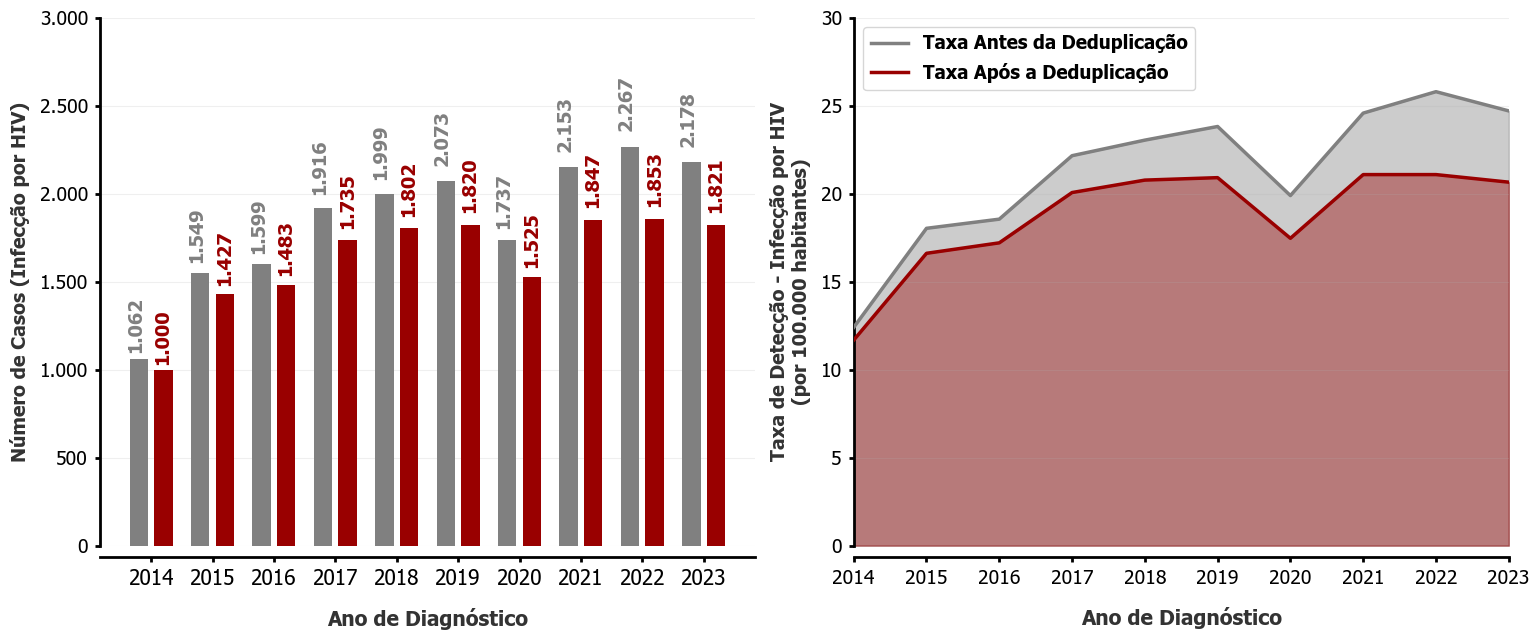

In [238]:
# -- total no estado
fig, (ax, ax2) = plt.subplots(1,2, figsize=(15.5,6.5))
#ax_twin = ax.twinx()

ax.grid(alpha=0.2, zorder=0, axis='y')
ax2.grid(alpha=0.2, zorder=0, axis='y')

# -- spines
for axis in [ax, ax2]:
    for i in ['left', 'right', 'bottom', 'top']:
        axis.spines[i].set_linewidth(2)
        #ax_twin.spines[i].set_linewidth(0)

        axis.spines['top'].set_linewidth(0)
        axis.spines['right'].set_linewidth(0)
        axis.spines['bottom'].set_position(('outward', 8))
#ax.spines['left'].set_position(('outward', 12))

bar_width=0.3
# -- plot data
ax.bar(dedup_count_df1['ANO']-0.2, dedup_count_df1['Antes da Dupli'], width=bar_width, zorder=2, color="#808080", alpha=1.0, label="Óbitos por qualquer causa básica")
ax.bar(dedup_count_df1['ANO']+0.2, dedup_count_df1['Depois da Dupli'], width=bar_width, zorder=2, color="#990000", alpha=1.0, label="Óbitos por neoplasia (C00-C97)")
#ax.bar(messejana_serie['ANO_OBITO']-0.2, messejana_serie['count'], width=bar_width, zorder=4, label="Dr. Carlos Alberto Studart Gomes", color="#e1374b")
#ax.bar(sao_jose_serie['ANO_OBITO']+0.2, sao_jose_serie['count'], width=bar_width, zorder=4, label="São José de Doenças Infecciosas", color="#396a93")

ax2.plot(dedup_count_df1['ANO'], dedup_count_df1['Taxa Antes'], zorder=4, color="#808080", linewidth=2.5, ls='-', label="Taxa Antes da Deduplicação")
ax2.plot(dedup_count_df1['ANO'], dedup_count_df1['Taxa Depois'], zorder=4, color="#990000", linewidth=2.5, ls='-', label="Taxa Após a Deduplicação")
ax2.fill_between(dedup_count_df1['ANO'], dedup_count_df1['Taxa Antes'], color="#808080", alpha=0.4)
ax2.fill_between(dedup_count_df1['ANO'], dedup_count_df1['Taxa Depois'], color="#990000", alpha=0.4)


# -- ticks and labels
ax.set_xlabel("Ano de Diagnóstico", fontsize=15, weight='bold', labelpad=14, fontdict={'color': "#333333"})
ax2.set_xlabel("Ano de Diagnóstico", fontsize=15, weight='bold', labelpad=14, fontdict={'color': "#333333"})
ax.set_ylabel("Número de Casos (Infecção por HIV)", fontsize=14, weight='bold', labelpad=7, fontdict={'color': "#333333"})
ax2.set_ylabel("Taxa de Detecção - Infecção por HIV\n(por 100.000 habitantes)", fontsize=14, weight='bold', labelpad=7, fontdict={'color': "#333333"})
#ax2.set_ylabel("Taxa de Mortalidade (por 100.000 hab.)", fontsize=16, weight='bold', fontdict={'color': "#333333"}, labelpad=9)
ax.set_xticks([n for n in dedup_count_df1["ANO"].tolist()])
ax2.set_xticks([n for n in dedup_count_df1["ANO"].tolist()])
#ax.set_xticklabels([n if n%4000==0 else '' for n in dedup_count_df1["ANO"].tolist()], weight='bold', color="#333333")
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(",", ".")))
#ax2.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
#ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(",", ".")))

ax.set_ylim([0, 3000])
ax2.set_ylim([0, 30])
ax2.set_xlim([2014, 2023])

ax.tick_params(width=2, labelsize=14, pad=5)
ax2.tick_params(width=2, labelsize=14, pad=5)
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=14)

serie_data = dedup_count_df1
serie_sum = dedup_count_df1['Depois da Dupli'].sum()
for idx in range(len(serie_data)):
    porc = (serie_data['Depois da Dupli'].iat[idx]/serie_sum)*100
    print(porc, idx, serie_data['Depois da Dupli'].iat[idx])

    ax.text(x=serie_data['ANO'].iat[idx]+0.04, y=serie_data['Depois da Dupli'].iat[idx]*1.05, s=f'{serie_data["Depois da Dupli"].iat[idx]:,}'.replace(",", "."), 
                ha='left', rotation=90, fontsize=14, color="#990000", weight='bold')

serie_data = dedup_count_df1
serie_sum = dedup_count_df1['Antes da Dupli'].sum()
for idx in range(len(serie_data)):
    porc = (serie_data['Antes da Dupli'].iat[idx]/serie_sum)*100
    print(porc, idx, serie_data['Antes da Dupli'].iat[idx])

    ax.text(x=serie_data['ANO'].iat[idx]-0.41, y=serie_data['Antes da Dupli'].iat[idx]*1.05, s=f'{serie_data["Antes da Dupli"].iat[idx]:,}'.replace(",", "."), 
                ha='left', rotation=90, fontsize=14, color="#808080", weight='bold')


#ax.set_xticklabels([n if n%2==0 else '' for n in dedup_count_df1["ANO"].tolist() if n%2==0], weight='bold', color="#333333")
#ax2.set_xticklabels([n if n%2==0 else '' for n in dedup_count_df1["ANO"].tolist() if n%2==0], weight='bold', color="#333333")

ax2.legend(prop={'size':13.5, 'weight': 'bold'}, loc=2)
#ax.legend(prop={'size':15}, loc=1)
fig.tight_layout()
fig.savefig(basepath.joinpath("opas", "hiv_aids", "tx_infeccao_hiv_antes_depois.png"), dpi=200, bbox_inches="tight")
#fig.savefig(os.path.join(basepath, "opas", "neoplasias", "figs", "obitos_neoplasias.png"), dpi=300, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_2013_2023.png"), dpi=300, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_2013_2023.pdf"), dpi=300, bbox_inches='tight')

In [87]:
?ax.grid

Signature: ax.grid(visible=None, which='major', axis='both', **kwargs)
Docstring:
Configure the grid lines.

Parameters
----------
visible : bool or None, optional
    Whether to show the grid lines.  If any *kwargs* are supplied, it
    is assumed you want the grid on and *visible* will be set to True.

    If *visible* is *None* and there are no *kwargs*, this toggles the
    visibility of the lines.

which : {'major', 'minor', 'both'}, optional
    The grid lines to apply the changes on.

axis : {'both', 'x', 'y'}, optional
    The axis to apply the changes on.

**kwargs : `~matplotlib.lines.Line2D` properties
    Define the line properties of the grid, e.g.::

        grid(color='r', linestyle='-', linewidth=2)

    Valid keyword arguments are:

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
    alpha: scalar or None
    animated: bool
    

### **Prevalencia**

In [259]:
prevalence_map = prevalence_df["MUNICIPIO_RESIDENCIA"].value_counts().reset_index().rename({"MUNICIPIO_RESIDENCIA": "GEOCOD6", "count": "prevalencia_abs_1"}, axis=1)
prevalence_diag_map = prevalence_diag_df["MUNICIPIO_RESIDENCIA"].value_counts().reset_index().rename({"MUNICIPIO_RESIDENCIA": "GEOCOD6", "count": "prevalencia_abs_2"}, axis=1)

prevalence_map = geodata_df.merge(prevalence_map, how="left").fillna(0)
prevalence_diag_map = geodata_df.merge(prevalence_diag_map, how="left").fillna(0)

prevalence_map["Tx. Prevalencia 1"] = (prevalence_map["prevalencia_abs_1"]/prevalence_map['2022'])*100000
prevalence_diag_map["Tx. Prevalencia 2"] = (prevalence_diag_map["prevalencia_abs_2"]/prevalence_diag_map['2022'])*100000

c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sevig310\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sevig310\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


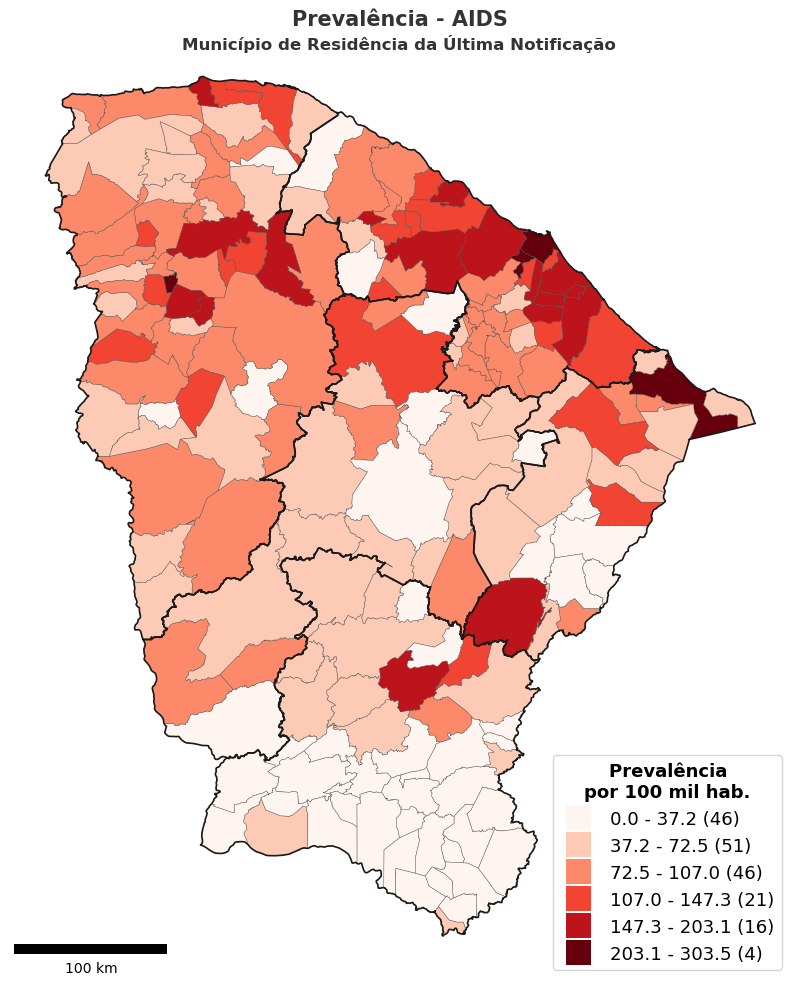

In [260]:
val = mapclassify.NaturalBreaks(prevalence_map['Tx. Prevalencia 1'], k=6)
bins = val.bins

def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.1f} - {label[1]:,.1f}'.replace(",",".")
    else:
        return f'{label[0]:,.1f} - {label[1]:,.1f} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(14.5,10))
prevalence_map.set_geometry("geometry_municip")
prevalence_map = prevalence_map.to_crs(epsg=29194)

nv_col = "Tx. Prevalencia 1"
map_counts = mapclassify.NaturalBreaks(prevalence_map[nv_col], k=6).counts
prevalence_map.plot(ax=ax_mapa, column=nv_col, edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': bins},
             cmap="Reds",
             linewidth=0.3,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.1f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = prevalence_map.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df = macro_df.to_crs(epsg=29194)
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#1a1a1a", linewidth=1.2)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

ax_mapa.add_artist(ScaleBar(1, location=3))

for axis in [ax_mapa]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(18)
        #line.set_linestyle('-')
        #line.set_linewidth(12)
        #line.set_color(cur_color)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label, map_counts) for index, label in enumerate(current_labels) ]
    l = axis.legend(lines, new_labels, prop={'size': 13}, loc=4, title=f'    Prevalência\npor 100 mil hab.', title_fontproperties={'weight': 'bold', 'size': 13,})
    l._legend_box.align = "center"

ax_mapa.set_title(f"Prevalência - AIDS", weight='bold', fontsize=15, color="#333333")
ax_mapa.text(x=320000, y=9710000, s="Município de Residência da Última Notificação", fontsize=12, weight='bold', color="#333333")
fig_mapa.tight_layout()
#fig_mapa.savefig(basepath.joinpath())
fig_mapa.savefig(basepath.joinpath("opas", "aids_municipios_20jun2024", "mapa_casos_aids_prevalencia_municipios_ce_def1.png"), dpi=200, bbox_inches="tight")
#fig_mapa.savefig(basepath.joinpath("opas", "prod4", "sifad_infec_mulheres_15a49_fig5_part2.png"), dpi=200, bbox_inches='tight')
#fig_mapa.savefig(basepath.joinpath("opas", "gabi_28mai", f"tx_dec_{preffix}_{nv_col.split('_')[-1]}_mesma_escala_com_2023.png"), dpi=200, bbox_inches='tight')
#fig_mapa.savefig(basepath.joinpath("opas", "sif_figs", f"tx_dec_sific_{nv_col.split('_')[-1]}.png"), dpi=300, bbox_inches='tight')

c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sevig310\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sevig310\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


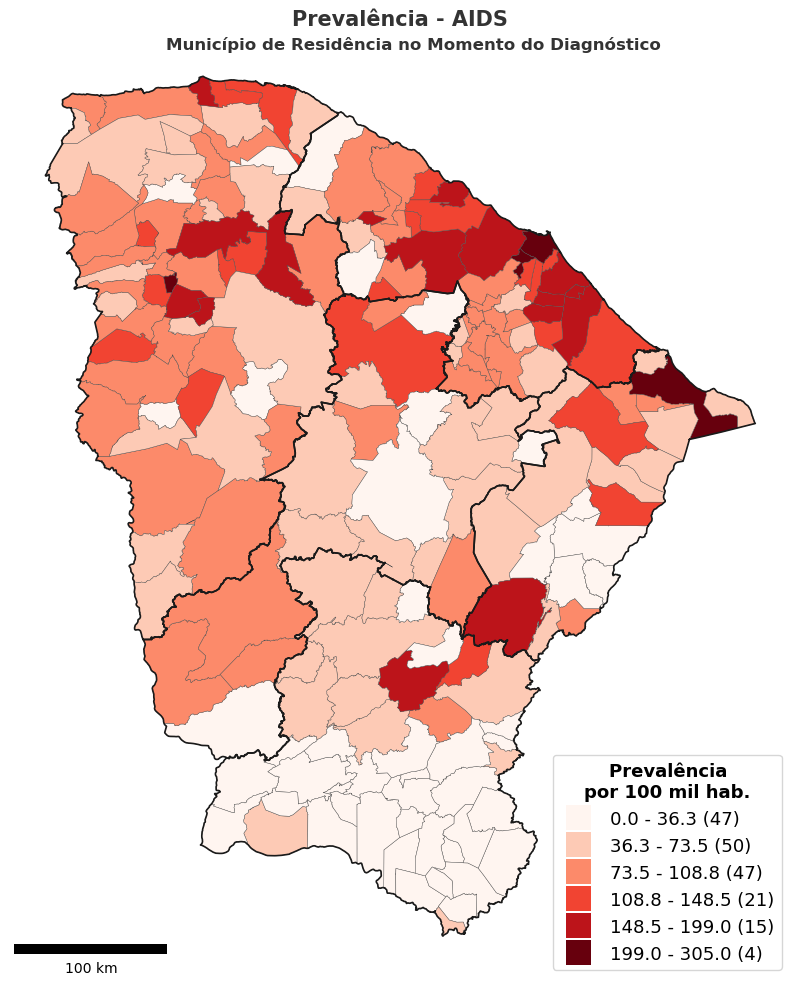

In [261]:
val = mapclassify.NaturalBreaks(prevalence_diag_map['Tx. Prevalencia 2'], k=6)
bins = val.bins

def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.1f} - {label[1]:,.1f}'.replace(",",".")
    else:
        return f'{label[0]:,.1f} - {label[1]:,.1f} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(14.5,10))
prevalence_diag_map.set_geometry("geometry_municip")
prevalence_diag_map = prevalence_diag_map.to_crs(epsg=29194)

nv_col = "Tx. Prevalencia 2"
map_counts = mapclassify.NaturalBreaks(prevalence_diag_map[nv_col], k=6).counts
prevalence_diag_map.plot(ax=ax_mapa, column=nv_col, edgecolor="#4d4d4d", 
             legend=True,
             scheme="user_defined",
             classification_kwds={'bins': bins},
             cmap="Reds",
             linewidth=0.3,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.1f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = prevalence_diag_map.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df = macro_df.to_crs(epsg=29194)
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#1a1a1a", linewidth=1.2)

ax_mapa.axis('off')
#ax_mapa.tick_params(which='both', length=0, labelsize=0)

ax_mapa.add_artist(ScaleBar(1, location=3))

for axis in [ax_mapa]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(18)
        #line.set_linestyle('-')
        #line.set_linewidth(12)
        #line.set_color(cur_color)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label, map_counts) for index, label in enumerate(current_labels) ]
    l = axis.legend(lines, new_labels, prop={'size': 13}, loc=4, title=f'    Prevalência\npor 100 mil hab.', title_fontproperties={'weight': 'bold', 'size': 13,})
    l._legend_box.align = "center"

ax_mapa.set_title(f"Prevalência - AIDS", weight='bold', fontsize=15, color="#333333")
ax_mapa.text(x=309000, y=9710000, s="Município de Residência no Momento do Diagnóstico", fontsize=12, weight='bold', color="#333333")
fig_mapa.tight_layout()
fig_mapa.savefig(basepath.joinpath("opas", "aids_municipios_20jun2024", "mapa_casos_aids_prevalencia_municipios_ce_def2.png"), dpi=200, bbox_inches="tight")

In [243]:
preval_map = prevalence_df["MUNICIPIO_RESIDENCIA"].value_counts().reset_index().rename({"MUNICIPIO_RESIDENCIA": "GEOCOD6", "count": "prevalencia_abs_1"}, axis=1)
preval_diag_map = prevalence_diag_df["MUNICIPIO_RESIDENCIA"].value_counts().reset_index().rename({"MUNICIPIO_RESIDENCIA": "GEOCOD6", "count": "prevalencia_abs_2"}, axis=1)

preval_map = preval_map.merge(geodata_df[["GEOCOD6", "NM_MUNICIP", "2022"]], how="left")
preval_diag_map = preval_diag_map.merge(geodata_df[["GEOCOD6", "NM_MUNICIP", "2022"]], how="left")

preval_df = preval_map.merge(preval_diag_map[["GEOCOD6", "prevalencia_abs_2"]], how="left")

cols = ["GEOCOD6", "NM_MUNICIP", "2022", "prevalencia_abs_1", "prevalencia_abs_2"]

preval_df = preval_df[cols].rename({"prevalencia_abs_1": "Casos Vivos Existentes - Aids (Def. 1)",
                                    "prevalencia_abs_2": "Casos Vivos Existentes - Aids (Def. 2)"}, axis=1)

preval_df["UF"] = preval_df["GEOCOD6"].apply(lambda x: x[:2])
preval_df = preval_df[preval_df["UF"]=="23"]

preval_df["Preval. 100 mil (Def. 1)"] = (preval_df["Casos Vivos Existentes - Aids (Def. 1)"]/preval_df["2022"])*100000
preval_df["Preval. 100 mil (Def. 2)"] = (preval_df["Casos Vivos Existentes - Aids (Def. 2)"]/preval_df["2022"])*100000
preval_df = preval_df.drop(columns=["UF"])

preval_df

,GEOCOD6,NM_MUNICIP,2022,Casos Vivos Existentes - Aids (Def. 1),Casos Vivos Existentes - Aids (Def. 2),Preval. 100 mil (Def. 1),Preval. 100 mil (Def. 2)
0,230440,FORTALEZA,2428678.0,7372,7407.0,303.539621,304.980734
1,230370,CAUCAIA,355679.0,557,559.0,156.601880,157.164185
2,230765,MARACANAÚ,234392.0,531,529.0,226.543568,225.690297
3,231290,SOBRAL,203023.0,408,404.0,200.962453,198.992232
4,230110,ARACATI,75112.0,168,171.0,223.665992,227.660028
...,...,...,...,...,...,...,...
187,230480,GRANJEIRO,4841.0,1,1.0,20.656889,20.656889
191,231325,TARRAFAS,7529.0,1,1.0,13.281976,13.281976
192,230710,JARDIM,27411.0,1,1.0,3.648170,3.648170
193,231210,SANTANA DO CARIRI,16954.0,1,NaN,5.898313,NaN


In [247]:
df_def = {
    "Definição 1": "Município de Residência da Última Notificação",
    "Definição 2": "Município de Residência no Momento do Diagnóstico"
}
df_def = pd.DataFrame(df_def, index=[0])

In [249]:
# -- define the file path
path_to_file = basepath.joinpath("opas", "aids_municipios_20jun2024", "casos_aids_prevalencia_municipios_ce.xlsx")

# Use ExcelWriter to save DataFrames to different sheets
with pd.ExcelWriter(path_to_file, engine='openpyxl') as writer:
    preval_df.to_excel(writer, sheet_name='Casos Vivos Existentes', index=False)
    df_def.to_excel(writer, sheet_name='Definições', index=False)

**Taxa de detecção HIV**